In [163]:
import numpy as np
from PIL import Image

Left image shape: (375, 450)
Right image shape: (375, 450)


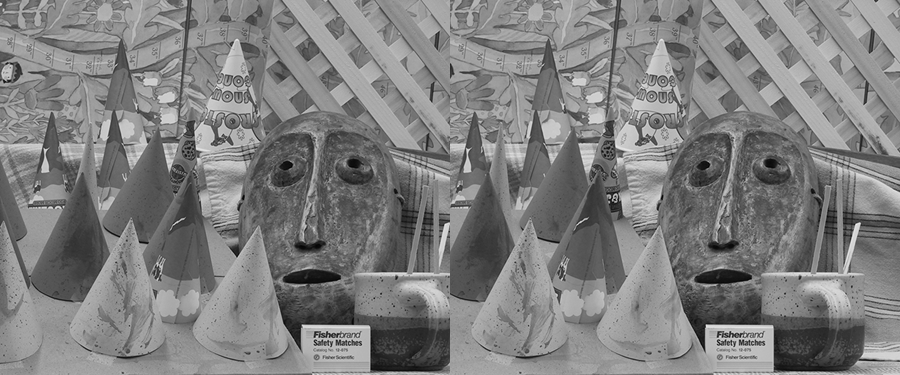

In [164]:
left_img = np.array(
    Image.open("./input/2003/cones/im2.png").convert("L"),
    dtype=np.int16,
)
right_img = np.array(
    Image.open("./input/2003/cones/im6.png").convert("L"),
    dtype=np.int16,
)
window_size = (5, 5)
max_disp_level = 64

print("Left image shape:", left_img.shape)
print("Right image shape:", right_img.shape)
assert left_img.shape == right_img.shape, (
    "Left and right images must have the same shape"
)

images = np.concatenate((left_img, right_img), axis=1)

display(Image.fromarray(images.astype(np.uint8)))

In [ ]:
def compute_census_value(
    img: np.ndarray, x_start: int, y_start: int, window_size: tuple[int, int]
) -> np.ndarray:
    """
    compute the census value in one window
    Args:
        img (np.ndarray): image
        x_start (int): start of window in x axis
        y_start (int): start of window in y axis
        window_size (tuple[int, int]): window size

    Returns:
        1-D array composed of 0s and 1s
    """

    window_h, window_w = window_size
    y_offset = window_h // 2
    window = img[y_start : y_start + window_h, x_start : x_start + window_w]
    # perform central symmetry operations
    center_symmetry_window = window[::-1, ::-1]
    census_value = np.where((window - center_symmetry_window) > 0, 1, 0)
    return census_value[: y_offset + 1].flatten()


def compute_census_value1(
    img: np.ndarray, x_start: int, y_start: int, window_size: tuple[int, int]
) -> np.ndarray:
    """
    compute the census value in one window
    Args:
        img (np.ndarray): image
        x_start (int): start of window in x axis
        y_start (int): start of window in y axis
        window_size (tuple[int, int]): window size

    Returns:
        1-D array composed of 0s and 1s
    """

    window_h, window_w = window_size
    # pick the center pixel
    center = img[y_start + window_h // 2, x_start + window_w // 2]
    window = img[y_start : y_start + window_h, x_start : x_start + window_w]
    census_value = np.where((window - center) < 0, 0, 1).flatten()
    return census_value


def census_transform(
    left_img: np.ndarray,
    right_img: np.ndarray,
    window_size: tuple[int, int],
) -> tuple[np.ndarray, np.ndarray]:
    """
    census transform
    Args:
        left_img (np.ndarray): left image
        right_img (np.ndarray): right image
        window_size (tuple[int, int]): the transform window size (sliding window size)
    Returns:
        transform result of left image and right image
    """

    height, width = left_img.shape
    window_h, window_w = window_size

    # need offset, pixel on the border of the image cannot be processed
    x_offset = window_w // 2
    y_offset = window_h // 2

    # size = window_w * (y_offset + 1)
    size = window_w * window_h
    left_census_value = np.zeros((height, width, size), dtype=np.int16)
    right_census_value = np.zeros((height, width, size), dtype=np.int16)

    for x in range(x_offset, width - x_offset):
        for y in range(y_offset, height - y_offset):
            x_start = x - x_offset
            y_start = y - y_offset

            # process left image
            left_census_value[y, x] = compute_census_value1(
                left_img, x_start, y_start, window_size
            )

            # process right image
            right_census_value[y, x] = compute_census_value1(
                right_img, x_start, y_start, window_size
            )
    return left_census_value, right_census_value


left_census_value, right_census_value = census_transform(
    left_img, right_img, window_size
)
print(f"census value shape: {left_census_value.shape}")

census value shape: (375, 450, 25)


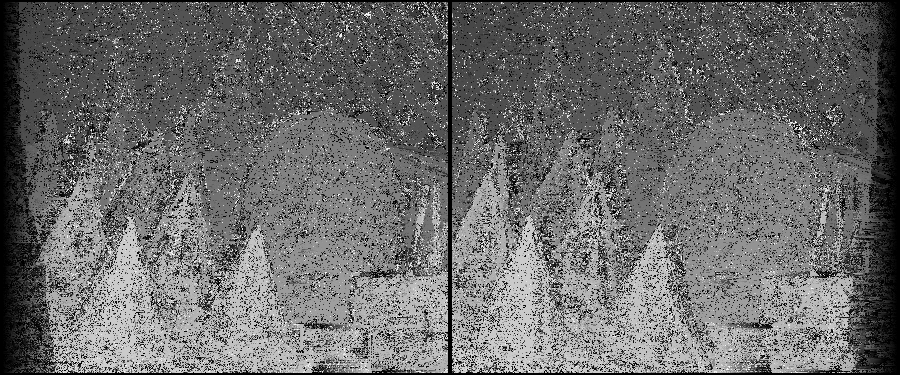

In [ ]:
def compute_cost_volume(
    left_census_value: np.ndarray,
    right_census_value: np.ndarray,
    max_disp_level: int,
    window_size: tuple[int, int],
) -> tuple[np.ndarray, np.ndarray]:
    """
    compute cost volume using hamming distance
    Args:
        left_census_value (np.ndarray): left image census transform result
        right_census_value (np.ndarray): right image census transform result
        max_disp_level (int): maximum disparity level
        window_size (tuple[int, int]): the transform window size (sliding window size)
    """

    height, width = left_census_value.shape[:2]
    x_offset = window_size[1] // 2
    left_cost_volume = np.zeros((height, width, max_disp_level))
    right_cost_volume = np.zeros((height, width, max_disp_level))
    tmp_left_census = np.zeros_like(left_census_value, dtype=np.int16)
    tmp_right_census = np.zeros_like(right_census_value, dtype=np.int16)

    for disp in range(max_disp_level):
        # compute left cost volume
        # pixel in left image <-> (pixel - disp) in right image
        tmp_right_census[:, x_offset + disp : width - x_offset] = right_census_value[
            :, x_offset : width - x_offset - disp
        ]
        # compute hamming distance
        hamming_dist = np.bitwise_xor(left_census_value, tmp_right_census).sum(axis=2)
        # fill left cost volume
        left_cost_volume[:, :, disp] = hamming_dist

        # compute right cost volume
        # pixel in right image <-> (pixel + disp) in left image
        tmp_left_census[:, x_offset : width - x_offset - disp] = left_census_value[
            :, x_offset + disp : width - x_offset
        ]
        # compute hamming distance
        hamming_dist = np.bitwise_xor(tmp_left_census, right_census_value).sum(axis=2)
        # fill right cost volume
        right_cost_volume[:, :, disp] = hamming_dist

    return left_cost_volume, right_cost_volume


left_cost_volume, right_cost_volume = compute_cost_volume(
    left_census_value, right_census_value, max_disp_level, window_size
)


def normalize(disp: np.ndarray, max_disp_level):
    """
    Normalizes the disparity map, then quantizes it so that it can be displayed.
    Args:
        disp (np.ndarray): disparity map with dimensions H x W.
        max_disp_level (int): maximum disparity of the array.

    Returns:
        normalized then quantized array, ready for visualization.
    """
    return 255.0 * disp / max_disp_level


left_costs = np.uint8(normalize(np.argmin(left_cost_volume, axis=2), max_disp_level))
right_costs = np.uint8(normalize(np.argmin(right_cost_volume, axis=2), max_disp_level))

images = np.concatenate([left_costs, right_costs], axis=1)
display(Image.fromarray(images))

In [156]:
def gen_penalties(max_disp_level: int, P1: int, P2: int) -> np.ndarray:
    """
    generate penalties based on the P1 and P2 values
    Args:
        max_disp_level (int): maximum disparity level
        P1 (int): penalty for a disparity change of 1
        P2 (int): penalty for a disparity change greater than 1
    """

    p1 = np.full((max_disp_level, max_disp_level), P1 - P2, dtype=np.int16)
    p2 = np.full((max_disp_level, max_disp_level), P2, dtype=np.int16)
    p1 = np.triu(p1, k=-1)
    p1 = np.tril(p1, k=1)
    no_penalty = np.identity(max_disp_level, dtype=np.int16) * -P1
    return p1 + p2 + no_penalty


def compute_path_cost(slice: np.ndarray, penalties: np.ndarray):
    """
    compute cost along one path
    Args:
        slice (np.ndarray): cost volume slice along one path
        penalties (np.ndarray): penalties for disparity changes

    Returns:
        cost along the path
    """

    other_dim, max_disp_level = slice.shape
    costs = np.zeros((other_dim, max_disp_level), dtype=np.int16)
    # initialize the first row of costs, which does not have any previous costs
    costs[0, :] = slice[0, :]

    # start loop from the second row
    for index in range(1, other_dim):
        prev_cost = costs[index - 1, :]
        curr_cost = slice[index, :]
        cost = np.repeat(prev_cost, repeats=max_disp_level).reshape(
            max_disp_level, max_disp_level
        )
        cost += penalties
        cost = cost.min(axis=0) + curr_cost - prev_cost.min()
        costs[index, :] = cost
    return costs


def aggregate_cost(
    cost_volume: np.ndarray, P1: int, P2: int, max_disp_level: int
) -> np.ndarray:
    """
    Aggregate cost volume along 4 paths (left, right, up, down) using penalties.
    Args:
        cost_volume (np.ndarray): cost volume with shape (H, W, D)
        P1 (int): penalty for a disparity change of 1
        P2 (int): penalty for a disparity change greater than 1
        max_disp_level (int): maximum disparity level

    """
    height, width = cost_volume.shape[:2]

    penalties = gen_penalties(max_disp_level, P1, P2)
    up_down_cost = np.zeros_like(cost_volume, dtype=np.int16)
    down_up_cost = np.zeros_like(cost_volume, dtype=np.int16)

    for w in range(width):
        up_down_slice = cost_volume[:, w, :]
        down_up_slice = np.flip(up_down_slice, axis=0)

        up_down_cost[:, w, :] = compute_path_cost(up_down_slice, penalties)
        down_up_cost[:, w, :] = np.flip(
            compute_path_cost(down_up_slice, penalties), axis=0
        )

    left_right_cost = np.zeros_like(cost_volume, dtype=np.int16)
    right_left_cost = np.zeros_like(cost_volume, dtype=np.int16)

    for h in range(height):
        left_right_slice = cost_volume[h, :, :]
        right_left_slice = np.flip(left_right_slice, axis=0)

        left_right_cost[h, :, :] = compute_path_cost(left_right_slice, penalties)
        right_left_cost[h, :, :] = np.flip(
            compute_path_cost(right_left_slice, penalties), axis=0
        )

    aggregate_cost = np.concatenate(
        (
            left_right_cost[..., np.newaxis],
            right_left_cost[..., np.newaxis],
            up_down_cost[..., np.newaxis],
            down_up_cost[..., np.newaxis],
        ),
        axis=3,
    )
    return aggregate_cost.sum(axis=3)


left_agg_cost = aggregate_cost(left_cost_volume, 10, 120, max_disp_level)
right_agg_cost = aggregate_cost(right_cost_volume, 10, 120, max_disp_level)

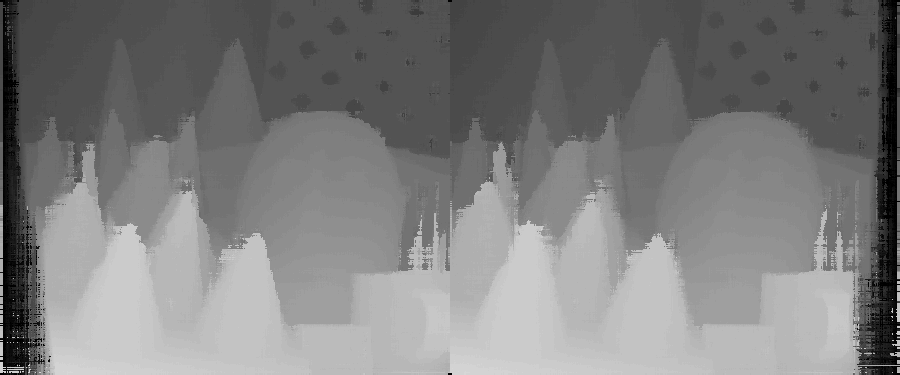

In [157]:
def select_disparity(cost_volume: np.ndarray) -> np.ndarray:
    """
    Select the disparity with the minimum cost for each pixel.
    Args:
        cost_volume (np.ndarray): aggregated cost volume with shape (H, W, D)

    Returns:
        disparity map with shape (H, W)
    """
    return np.argmin(cost_volume, axis=2)


left_disp = select_disparity(left_agg_cost)
right_disp = select_disparity(right_agg_cost)

left_disparity_map = np.uint8(
    normalize(select_disparity(left_agg_cost), max_disp_level)
)
right_disparity_map = np.uint8(
    normalize(select_disparity(right_agg_cost), max_disp_level)
)

images = np.concatenate([left_disparity_map, right_disparity_map], axis=1)
display(Image.fromarray(images))

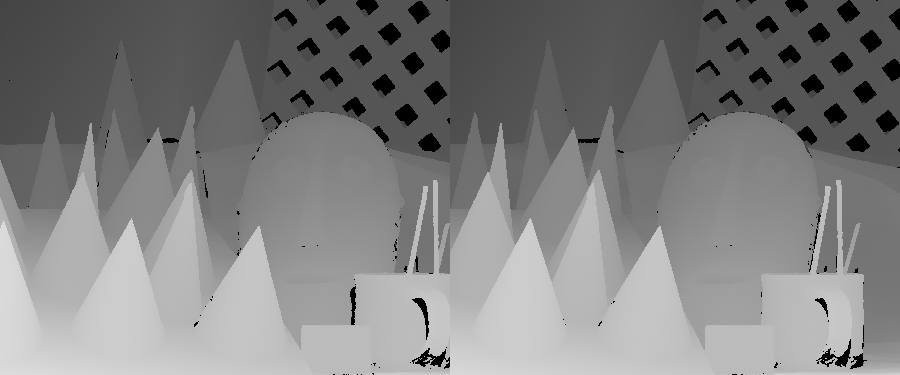

In [ ]:
left_disp_gt = np.array(
    Image.open("./input/2003/cones/disp2.png"),
    dtype=np.uint8,
)
right_disp_gt = np.array(
    Image.open("./input/2003/cones/disp6.png"),
    dtype=np.uint8,
)

images = np.concatenate([left_disp_gt, right_disp_gt], axis=1)
display(Image.fromarray(images))

In [159]:
def evaluate(disp: np.ndarray, disp_gt: np.ndarray, max_disp_level: int) -> float:
    """
    Evaluate the disparity map against the ground truth.
    Args:
        disp (np.ndarray): disparity map with shape (H, W)
        disp_gt (np.ndarray): ground truth disparity map with shape (H, W)
        max_disp_level (int): maximum disparity level

    Returns:
        percentage of correct pixels
    """

    gt = np.int16(disp_gt.astype(np.float16) / 255.0 * max_disp_level)
    correct_pixels = np.abs(disp - gt) < 3  # threshold of 3 pixels
    total_pixels = disp.size
    return correct_pixels.sum() / total_pixels * 100.0


left_evaluate = evaluate(left_disp, left_disp_gt, max_disp_level)
right_evaluate = evaluate(right_disp, right_disp_gt, max_disp_level)
print(f"Left disparity evaluation: {left_evaluate:.2f}%")
print(f"Right disparity evaluation: {right_evaluate:.2f}%")

Left disparity evaluation: 84.04%
Right disparity evaluation: 83.93%
